In [1]:
pip install pdfminer pdfminer.six PyPDF2 gensim wordcloud pdfplumber

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Importing relevant libraries
from pdfminer.high_level import extract_text
import PyPDF2
from PyPDF2 import PdfReader
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import download
from gensim import corpora, models
from gensim.models import CoherenceModel
import os
import statistics
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import pearsonr
import matplotlib.pyplot
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
import tensorflow as tf
import os
import pdfplumber
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from gensim.corpora import Dictionary
from gensim.models import HdpModel
import tensorflow as tf
import torch
import multiprocessing


# Download other resources
download('stopwords')
download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
#Initial stats - file count

def count_files_in_folder(folder_path):
    # Initialize a counter for files
    file_count = 0

    # Walk through the directory and count files
    for _, _, files in os.walk(folder_path):
        file_count += len(files)

    return file_count

folder_path = '/notebooks/CIND820/Datasource'
total_files = count_files_in_folder(folder_path)
print("Total files in datasource: ", total_files)

Total files in datasource:  1971


In [4]:
#Initial stats - page count

def count_pages_and_stats(folder_path):
    total_pages = 0
    page_counts = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as file:
                pdf_reader = PdfReader(file)
                num_pages = len(pdf_reader.pages)
                total_pages += num_pages
                page_counts.append(num_pages)

    mean_page_count = statistics.mean(page_counts)
    median_page_count = statistics.median(page_counts)

    return total_pages, mean_page_count, median_page_count

folder_path = '/notebooks/CIND820/Datasource'
total_pages, mean_page_count, median_page_count = count_pages_and_stats(folder_path)

print("Total pages in all PDF files:", total_pages)
print("Mean page count per file:", mean_page_count)
print("Median page count per file:", median_page_count)

Total pages in all PDF files: 155385
Mean page count per file: 78.8756345177665
Median page count per file: 80.0


In [5]:
%%time
# Function for preprocessing text
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Remove punctuation and convert to lowercase
    tokens = [token.lower() for token in tokens if token.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    french_stopwords = set(stopwords.words('french'))
    stop_words.update(french_stopwords)
    # Remove specific words or letters which are not useful
    additional_stopwords = [
        'mr.', 'mr', 'mrs.', 'ms.', 'speaker', 'bill', 'debate', 'hon', 'cpc', 'lib', 'bq', 'canadian', 
        'act', 'amend', 'amendment', 'canada', 'house', 'public', 'honour', 'minister', 'ministry', 'govern', 
        'member', 'program', 'primeminister', 'would', 'people', 'chair', 'committe', 'liber', 'polici', 'parliamentari', 
        'ndp', 'government', 'conserv', 'parties', 'partisan', 's', 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'am', 'pm','year','time','motion','go', 'canadians', 
        'also', 'members', 'madam', 'committee', 'prime', 'senate', 'senator', 'hous',
        'one', 'govern', 'liberal', 'conservative', 'liberals', 'conservatives', 'speech', 'parliamentarian',
        'secretariat', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', '000', '1', '3', '5', '11', 
        '15', '22', '25', '2007', '2008', '2009', '2010', '2011',
        '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '‚Äô',
        '‚Äú', '‚Äù', "’",'...................',' ................................................',
        '........',"'s"]
    stop_words.update(additional_stopwords)
    tokens = [token for token in tokens if token not in stop_words]
    # Remove numbers, symbols, and certain words
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

# Directory path containing PDF files
pdf_directory = '/notebooks/CIND820/Datasource'

# List all PDF files in the directory
pdf_files = [os.path.join(pdf_directory, file) for file in os.listdir(pdf_directory) if file.endswith('.pdf')]

texts = []

# Loop through each PDF file and extract text
for pdf_file in pdf_files:
    with pdfplumber.open(pdf_file) as pdf:
        text = ""
        for page in pdf.pages:
            text += page.extract_text()
        texts.append(text)

# Preprocess text
preprocessed_texts = [preprocess_text(text) for text in texts]

# Create a dictionary from the preprocessed text
dictionary = Dictionary(preprocessed_texts)

# Create a corpus
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]

    

CPU times: user 6h 23min 39s, sys: 1min 41s, total: 6h 25min 20s
Wall time: 6h 26min 21s


In [6]:
%%time
#spliting data for cross validation
from sklearn.model_selection import train_test_split

train_corpus, test_corpus = train_test_split(corpus, test_size=0.2, random_state=42)

CPU times: user 1.33 ms, sys: 0 ns, total: 1.33 ms
Wall time: 1.27 ms


In [7]:
%%time
# Train the HDP model
hdp_model = HdpModel(train_corpus, id2word=dictionary, max_chunks=23)

CPU times: user 50min 53s, sys: 57min 9s, total: 1h 48min 3s
Wall time: 15min 57s


In [8]:
%%time
#First evaluation of HDP model and number of topics identified per document)
rows = []

# Iterate through each document in the corpus
for i, doc in enumerate(corpus):
    doc_topics = hdp_model[doc]
    # Extract topic numbers and their probabilities
    topic_numbers = [topic[0] for topic in doc_topics]
    topic_probs = [topic[1] for topic in doc_topics]
    # Append the document's topics to the rows list
    rows.append([i, topic_numbers, topic_probs])

# Create a DataFrame from the list of rows
doc_topics_df = pd.DataFrame(rows, columns=['Document_Index', 'Topic_Numbers', 'Topic_Probabilities'])

# Display the DataFrame
doc_topics_df.head(10)

CPU times: user 13min 2s, sys: 10min 49s, total: 23min 51s
Wall time: 2min 29s


,Document_Index,Topic_Numbers,Topic_Probabilities
0,0,"[0, 1, 6, 25]","[0.8253534430054159, 0.077472882922487, 0.0178..."
1,1,[1],[0.9999509368079036]
2,2,"[0, 1]","[0.22171735455962982, 0.7723314528917588]"
3,3,[0],[0.9999800145261954]
4,4,[1],[0.9999645659240654]
5,5,"[0, 1]","[0.9641942180665692, 0.021668186716909368]"
6,6,[1],[0.9999580695744752]
7,7,"[0, 3, 25]","[0.42904754761298824, 0.5368120904503535, 0.03..."
8,8,"[0, 1, 31]","[0.8170735246497098, 0.07354199502906827, 0.10..."
9,9,[0],[0.9900797852570569]


In [9]:
%%time
# To find an approximate number of total topics identified within the HDP model, I found it easiest to train an
#LDA model on the HDP model. 
# Here we'll train an LDA model using the HDP model as a training mechanism
lda_model_t = hdp_model.suggested_lda_model()

# Get the topic distributions for each document
doc_topics = [lda_model_t.get_document_topics(doc) for doc in corpus]

# Count the number of unique topics
unique_topics = set()
for doc_topics in doc_topics:
    unique_topics.update([topic[0] for topic in doc_topics])

num_topics_identified = len(unique_topics)
print(f"Number of topics identified by HDP model: {num_topics_identified}")

Number of topics identified by HDP model: 44
CPU times: user 7min 38s, sys: 6min 40s, total: 14min 18s
Wall time: 1min 50s


In [10]:
%%time
#Crossvalidation using an n-fold analysis showed that the ideal number of topics for LDA was 7. 
from gensim.models import LdaModel

# Train the LDA model
lda_model = LdaModel(train_corpus, id2word=dictionary, num_topics=7, update_every=1, chunksize=10, passes=10)

CPU times: user 1h 17min 7s, sys: 35min 38s, total: 1h 52min 46s
Wall time: 57min 10s


In [23]:
%%time
#Evaluating LDA topic coherance values. 
from gensim.models import CoherenceModel

# Calculate coherence values for each topic
coherence_values = {}
for topic_num in range(lda_model.num_topics):
    topic_terms = lda_model.show_topic(topic_num)
    topic_words = [term for term, _ in topic_terms]
    coherence_model = CoherenceModel(topics=[topic_words], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_values[topic_num] = coherence_model.get_coherence()

# Create a table of coherence values
print("Topic\tCoherence Value")
for topic_num, coherence_value in coherence_values.items():
    print(f"{topic_num}\t{coherence_value}")

Topic	Coherence Value
0	0.2877520946346136
1	0.4072832441954907
2	0.2877520946346136
3	0.2877520946346136
4	0.2877520946346136
5	0.5201127737203777
6	0.2877520946346136
CPU times: user 5min 21s, sys: 2min 24s, total: 7min 46s
Wall time: 9min 20s


In [24]:
%%time
# Finding the overall LDA model coherance value
topics = lda_model.show_topics(num_topics=-1, formatted=False)

# Calculate coherence values for each topic
coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print("Coherence Score for LDA model:", coherence_lda)

Coherence Score for LDA model: 0.4838705994123883
CPU times: user 47.8 s, sys: 20.6 s, total: 1min 8s
Wall time: 1min 43s


In [25]:
%%time
#Evaluating HDP topic coherance values, which were found to have a range below as well as above the LDA model
from gensim.models import CoherenceModel

hdp_topics = hdp_model.show_topics(num_topics=42, formatted=False)  # Get the top topics

# Extract topic words for each topic
topic_words = [[word for word, _ in topic] for topic_id, topic in hdp_topics]

# Calculate coherence values for each topic
coherence_values = {}
for topic_num, words in enumerate(topic_words):
    coherence_model = CoherenceModel(topics=[words], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_values[topic_num] = coherence_model.get_coherence()

# Create a table of coherence values
print("Topic\tCoherence Value")
for topic_num, coherence_value in coherence_values.items():
    print(f"{topic_num}\t{coherence_value}")

Topic	Coherence Value
0	0.31097972213760794
1	0.36657245798384186
2	0.36379747052706735
3	0.2961260355057365
4	0.2572518690754245
5	0.3475858236367159
6	0.38161437100159673
7	0.3347228150652374
8	0.3078476751753149
9	0.3439878829171348
10	0.3302024879942712
11	0.30946572114611176
12	0.26264561701793576
13	0.35808041806000857
14	0.3178612322881995
15	0.25012210570691595
16	0.31915602490604644
17	0.3589114421519376
18	0.34744533528969324
19	0.34093999918071
20	0.30094768084867873
21	0.31758213653333833
22	0.29554883934558934
23	0.30463450821015764
24	0.3344966630888714
25	0.3547754280871431
26	0.4088582699835227
27	0.3462581512768639
28	0.41740185638713967
29	0.27305484454884477
30	0.2173206127948147
31	0.3335069187240501
32	0.2416487785530701
33	0.28455495856646973
34	0.2900785597990573
35	0.31303794587052575
36	0.2692111079049069
37	0.29658764258124537
38	0.2882780561799173
39	0.3495894802818034
40	0.34327623880891295
41	0.3049280125428918
CPU times: user 36min 8s, sys: 14min 42s, tota

In [26]:
%%time
# Finding the overall coherhance value for HDP model
hdp_topics = hdp_model.show_topics(num_topics=42, formatted=False)  # Get the top topics

# Extract topic words for each topic
topic_words = [[word for word, _ in topic] for topic_id, topic in hdp_topics]

# Calculate coherence values for each topic
coherence_values = {}
for topic_num, words in enumerate(topic_words):
    coherence_model = CoherenceModel(topics=[words], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_values[topic_num] = coherence_model.get_coherence()

# Compute the average coherence value
avg_coherence_value = sum(coherence_values.values()) / len(coherence_values)

print("Overall Coherence Value for HDP model:", avg_coherence_value)

Overall Coherence Value for HDP model: 0.31883079042107915
CPU times: user 35min 49s, sys: 14min 36s, total: 50min 26s
Wall time: 1h 12min 33s


In [27]:
%%time
#Generate df with dominant topics, the topic contribution and topic keywords for LDA model
import pandas as pd

def format_topics(ldamodel=None, corpus=None, texts=None):
    # Initialize an empty list to store rows
    rows = []

    # Iterate through each document in the corpus
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Extract dominant topic, its contribution, and keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                row_data = [int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]]
                rows.append(row_data)
                break

    # Create df
    topics_df = pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text'])

    return topics_df


df_topic_keywords = format_topics(ldamodel=lda_model, corpus=corpus, texts=preprocessed_texts)

df_topic_keywords.head(10)

CPU times: user 15min 19s, sys: 18min 34s, total: 33min 53s
Wall time: 2min 46s


,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,1,0.9997,"work, need, support, make, want, like, right, know, countri, english","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, octob, hon..."
1,1,1.0000,"work, need, support, make, want, like, right, know, countri, english","[parliament, session, common, debat, offici, report, hansard, volum, thursday, octob, honour, an..."
2,1,0.9978,"work, need, support, make, want, like, right, know, countri, english","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, februari, h..."
3,1,0.9976,"work, need, support, make, want, like, right, know, countri, english","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, march, ho..."
4,1,1.0000,"work, need, support, make, want, like, right, know, countri, english","[parliament, session, common, debat, offici, report, hansard, volum, tuesday, may, honour, antho..."
5,1,0.9999,"work, need, support, make, want, like, right, know, countri, english","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, may, honour..."
6,1,1.0000,"work, need, support, make, want, like, right, know, countri, english","[parliament, session, common, debat, offici, report, hansard, volum, thursday, decemb, honour, a..."
7,1,0.9970,"work, need, support, make, want, like, right, know, countri, english","[common, debat, volum, number, session, parliament, offici, report, hansard, wednesday, june, ho..."
8,1,0.9999,"work, need, support, make, want, like, right, know, countri, english","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, novemb, h..."
9,1,0.9723,"work, need, support, make, want, like, right, know, countri, english","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, june, hono..."


In [28]:
%%time
#Generate df of represtative text for dominant topics for LDA model
import pandas as pd

pd.options.display.max_colwidth = 100

topics_sorteddf_mallet = pd.DataFrame()
topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in topics_outdf_grpd:
    topics_sorteddf_mallet = pd.concat([topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format DF
topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]


topics_sorteddf_mallet.head(10)

CPU times: user 3.34 ms, sys: 3.84 ms, total: 7.18 ms
Wall time: 7.21 ms


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,1,1.0000,"work, need, support, make, want, like, right, know, countri, english","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, octob, hon..."
1,5,0.8595,"ontario, qubec, britishcolumbia, hawn, lukiwski, theminist, tom, associ, alberta, deanallison","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, april, hono..."


In [29]:
%%time
#Generate df with dominant topics, the topic contribution and topic keywords for HDP model
import pandas as pd

def topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Initialize an empty list to store rows
    rows = []

    # Iterate through each document in the corpus
    for i, topics in enumerate(ldamodel[corpus]):
        # Sort topics by contribution
        topics = sorted(topics, key=lambda x: (x[1]), reverse=True)

        # Extract dominant topic, its contribution, and keywords
        for j, (topic_num, prop_topic) in enumerate(topics):
            if j == 0:  # Dominant topic
                topic_keywords = ", ".join([word for word, prop in ldamodel.show_topic(topic_num)])
                row_data = [int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]]
                rows.append(row_data)
                break

    # Create df
    topics_df = pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text'])

    return topics_df

df_topic_keywords = topics_sentences(ldamodel=hdp_model, corpus=corpus, texts=preprocessed_texts)

df_topic_keywords.head(10)

CPU times: user 3h 58min 22s, sys: 1h 34min 26s, total: 5h 32min 48s
Wall time: 4h 33min 53s


,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,0,0.8254,"commonsdeb, work, english, make, support, order, like, translat, need, right, want, nation, coun...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, octob, hon..."
1,1,1.0000,"need, work, want, support, make, get, right, like, common, know, question, us, countri, mani, sa...","[parliament, session, common, debat, offici, report, hansard, volum, thursday, octob, honour, an..."
2,1,0.7723,"need, work, want, support, make, get, right, like, common, know, question, us, countri, mani, sa...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, februari, h..."
3,0,1.0000,"commonsdeb, work, english, make, support, order, like, translat, need, right, want, nation, coun...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, march, ho..."
4,1,1.0000,"need, work, want, support, make, get, right, like, common, know, question, us, countri, mani, sa...","[parliament, session, common, debat, offici, report, hansard, volum, tuesday, may, honour, antho..."
5,0,0.9642,"commonsdeb, work, english, make, support, order, like, translat, need, right, want, nation, coun...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, may, honour..."
6,1,1.0000,"need, work, want, support, make, get, right, like, common, know, question, us, countri, mani, sa...","[parliament, session, common, debat, offici, report, hansard, volum, thursday, decemb, honour, a..."
7,3,0.5368,"work, commonsdeb, order, commun, make, english, support, ontario, want, need, countri, like, tra...","[common, debat, volum, number, session, parliament, offici, report, hansard, wednesday, june, ho..."
8,0,0.8171,"commonsdeb, work, english, make, support, order, like, translat, need, right, want, nation, coun...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, novemb, h..."
9,0,0.9901,"commonsdeb, work, english, make, support, order, like, translat, need, right, want, nation, coun...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, june, hono..."


In [30]:
%%time
#Generate df of represtative text for dominant topics for HDP model
import pandas as pd

pd.options.display.max_colwidth = 100

topics_sorteddf_mallet = pd.DataFrame()
topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in topics_outdf_grpd:
    topics_sorteddf_mallet = pd.concat([topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
topics_sorteddf_mallet.head(10)

CPU times: user 24 ms, sys: 1.87 ms, total: 25.9 ms
Wall time: 23.4 ms


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,1.0000,"commonsdeb, work, english, make, support, order, like, translat, need, right, want, nation, coun...","[common, debat, volum, number, session, parliament, offici, report, hansard, wednesday, march, h..."
1,1,1.0000,"need, work, want, support, make, get, right, like, common, know, question, us, countri, mani, sa...","[parliament, session, common, debat, offici, report, hansard, volum, thursday, octob, honour, an..."
2,2,0.9999,"work, need, want, make, know, like, support, countri, order, import, get, say, take, right, mani...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, januari, ho..."
3,3,0.9990,"work, commonsdeb, order, commun, make, english, support, ontario, want, need, countri, like, tra...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, may, honour..."
4,4,0.9999,"ontario, qubec, parliamentari, english, commonsdeb, translat, nation, britishcolumbia, order, yo...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, may, honour..."
5,5,0.9998,"nation, work, want, question, order, need, right, common, like, make, support, issu, quebec, com...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, april, ho..."
6,6,0.9999,"work, need, want, health, support, like, right, know, care, make, question, say, common, get, co...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, januari, ho..."
7,7,0.9629,"work, want, make, health, commonsdeb, right, english, job, need, know, translat, like, support, ...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, februari, h..."
8,8,0.9449,"support, work, order, commonsdeb, nation, countri, english, like, translat, import, need, secur,...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, march, ho..."
9,9,0.9449,"need, work, support, like, commun, want, make, health, get, drug, know, tax, mani, countri, orde...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, april, hon..."


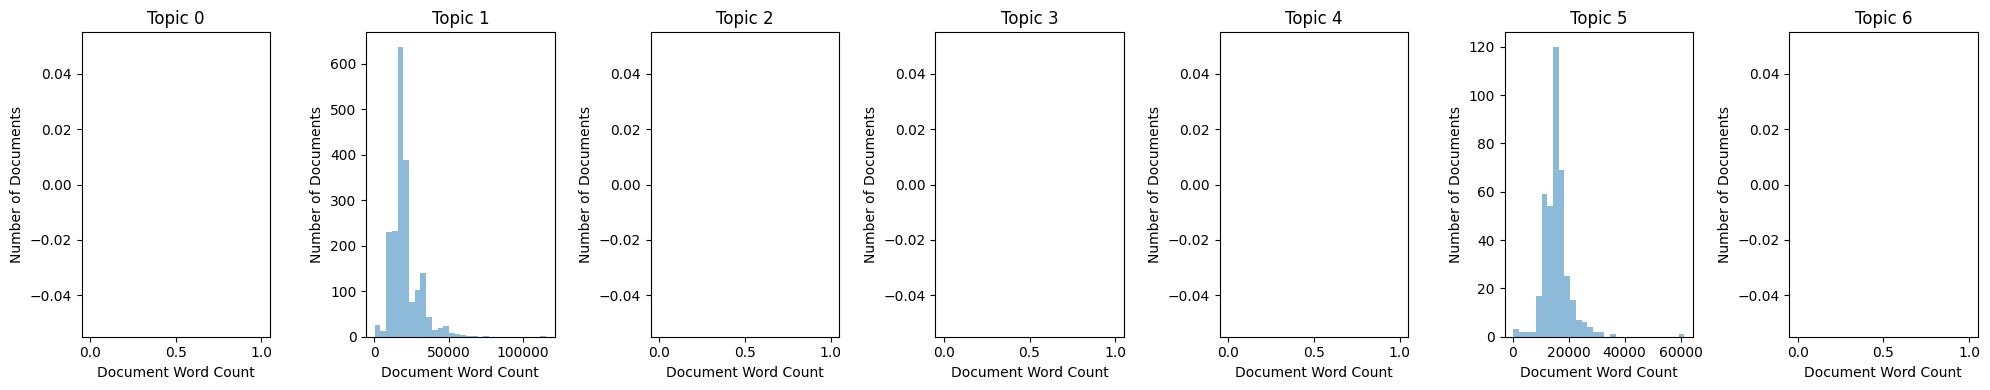

CPU times: user 6min 53s, sys: 8min 22s, total: 15min 16s
Wall time: 1min 15s


In [31]:
%%time
#Ploting document word count against nubmer of documents for LDA model
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20, 4))

for i in range(7):
    word_counts = []

    
    for doc in corpus:
        # Get the topic distribution for the document
        doc_topics = lda_model.get_document_topics(doc)

        # Check if the current topic is the dominant topic for the document
        for topic, prob in doc_topics:
            if topic == i:
                # Calculate the word count of the document and add it to the list
                word_count = sum(count for _, count in doc)
                word_counts.append(word_count)
                break

    axes[i].hist(word_counts, bins=30, alpha=0.5)
    axes[i].set_title(f'Topic {i}')
    axes[i].set_xlabel('Document Word Count')
    axes[i].set_ylabel('Number of Documents')

plt.tight_layout()
plt.show()

In [ ]:
%%time
#Ploting document word count against nubmer of documents for HDP model
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))


for i in range(42):
    word_counts = []

    for doc in corpus:
        doc_topics = hdp_model[doc]

        for topic, prob in doc_topics:
            if topic == i:
                word_count = sum(count for _, count in doc)
                word_counts.append(word_count)
                break

    # Determine the position of the subplot in the grid
    row_index = i // 5
    col_index = i % 5

    axes[row_index, col_index].hist(word_counts, bins=30, alpha=0.5)
    axes[row_index, col_index].set_title(f'Topic {i}')
    axes[row_index, col_index].set_xlabel('Document Word Count')
    axes[row_index, col_index].set_ylabel('Number of Documents')

plt.tight_layout()
plt.show()

In [39]:
pip install pyLDAvis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 61.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 78.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 108.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.6/375.6 kB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 85.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.4
    Uninstalling numpy-1.23.4:
      Successfully uninstalled numpy-1.23.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.0
    Uninstalling pandas-1.5.0:
      Successfully uninstalled pandas-1.5.0
Note: you may need to restart the kernel to use updated packages.


In [40]:
%%time
#Exploring the relevant terms for each topic of the LDA Model
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)

# Convert complex numbers to real numbers in topic coordinates
vis.topic_coordinates['x'] = vis.topic_coordinates['x'].apply(lambda x: x.real)
vis.topic_coordinates['y'] = vis.topic_coordinates['y'].apply(lambda y: y.real)

vis

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
%%time
#Exploring the relevant terms for each topic of the HDP Model
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(hdp_model, corpus, dictionary=dictionary)

# Convert complex numbers to real numbers in topic coordinates
vis.topic_coordinates['x'] = vis.topic_coordinates['x'].apply(lambda x: x.real)
vis.topic_coordinates['y'] = vis.topic_coordinates['y'].apply(lambda y: y.real)

vis